In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [64]:
df=pd.read_csv('Credit Card Spending in India.csv')
df=df.drop(['index','Date'],axis=1)
df.head()

,City,Card Type,Exp Type,Gender,Amount
0,"Delhi, India",Gold,Bills,F,82475.0
1,"Greater Mumbai, India",Platinum,Bills,F,32555.0
2,"Bengaluru, India",Silver,Bills,F,101738.0
3,"Greater Mumbai, India",Signature,Bills,F,123424.0
4,"Bengaluru, India",Gold,Bills,F,171574.0


In [65]:
df.columns

Index(['City', 'Card Type', 'Exp Type', 'Gender', 'Amount'], dtype='object')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       101 non-null    object 
 1   Card Type  101 non-null    object 
 2   Exp Type   101 non-null    object 
 3   Gender     101 non-null    object 
 4   Amount     101 non-null    float64
dtypes: float64(1), object(4)
memory usage: 1017.8+ KB


In [67]:
df['Amount'].isna().sum()

np.int64(25951)

In [68]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats.mstats import winsorize



num_cols=['Amount']
cat_cols=['City', 'Card Type', 'Exp Type', 'Gender']

def winso(x):
    return winsorize(x,limits=[0.10,0.10])

num_pipeline =Pipeline([
    ('num_imp',SimpleImputer(strategy='mean')),
    ("winsorize_num",FunctionTransformer(winso,feature_names_out='one-to-one')),
    ("scale",StandardScaler())

])

cat_pipeline =Pipeline([
    ("cat_imp",SimpleImputer(strategy='most_frequent')),
    #("winsorize_cat",winsorize(df[cat_cols],limits=[0.50,0.50])),
    ("ohe",OneHotEncoder(drop='first',handle_unknown='ignore'))
])

preprocess =ColumnTransformer(transformers=[
    ("num",num_pipeline,num_cols),
    ("cat",cat_pipeline,cat_cols)
])

dt =preprocess.fit_transform(df)

ohe_names=preprocess.named_transformers_['cat'].named_steps["ohe"]
ohe_cols =ohe_names.get_feature_names_out(cat_cols)

all_cols=num_cols+list(ohe_cols)
data = pd.DataFrame(dt,columns=all_cols)

data.head()


,Amount,"City_Bengaluru, India","City_Delhi, India","City_Greater Mumbai, India",Card Type_Platinum,Card Type_Signature,Card Type_Silver
0,5.820766e-11,0.0,1.0,0.0,0.0,0.0,0.0
1,5.820766e-11,0.0,0.0,1.0,1.0,0.0,0.0
2,5.820766e-11,1.0,0.0,0.0,0.0,0.0,1.0
3,5.820766e-11,0.0,0.0,1.0,0.0,1.0,0.0
4,5.820766e-11,1.0,0.0,0.0,0.0,0.0,0.0


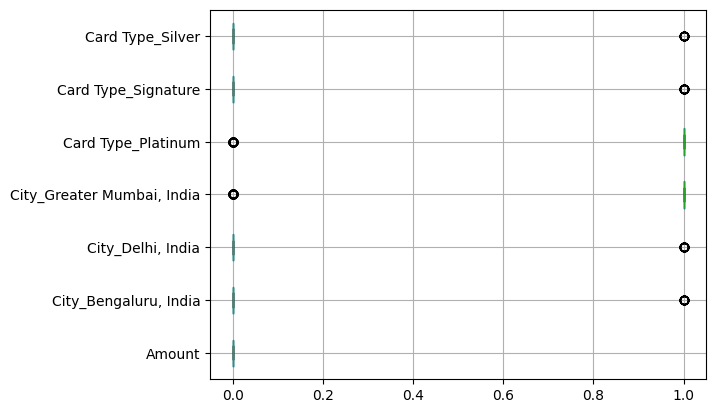

In [69]:
data.select_dtypes(include="number").boxplot(vert=False)
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (20). Possibl

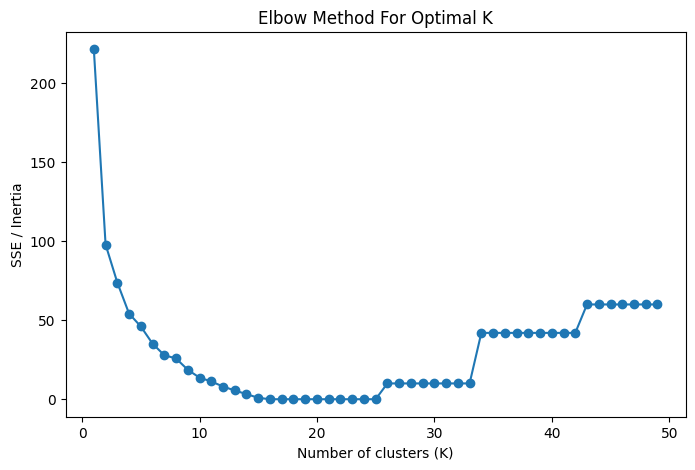

In [70]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
k_rng = range(1, 50)

for k in k_rng:
    km = KMeans(n_clusters=k, random_state=42)  # always set random_state
    km.fit(data)
    sse.append(km.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8,5))
plt.plot(k_rng, sse, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE / Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()


In [71]:
km =KMeans(n_clusters=3)
y_pred=km.fit_predict(data)

data['cluster']=y_pred
data.head()

,Amount,"City_Bengaluru, India","City_Delhi, India","City_Greater Mumbai, India",Card Type_Platinum,Card Type_Signature,Card Type_Silver,cluster
0,5.820766e-11,0.0,1.0,0.0,0.0,0.0,0.0,1
1,5.820766e-11,0.0,0.0,1.0,1.0,0.0,0.0,0
2,5.820766e-11,1.0,0.0,0.0,0.0,0.0,1.0,2
3,5.820766e-11,0.0,0.0,1.0,0.0,1.0,0.0,0
4,5.820766e-11,1.0,0.0,0.0,0.0,0.0,0.0,2


In [72]:
data.groupby('cluster')['Amount'].mean()


cluster
0    5.820766e-11
1    5.820766e-11
2    5.820766e-11
Name: Amount, dtype: float64

In [73]:
df_orig = df.copy()  # original dataframe before preprocessing
df_orig['cluster'] = y_pred

df_orig.groupby('cluster')[['City','Card Type','Exp Type','Gender']].agg(lambda x: x.value_counts().index[0])


,City,Card Type,Exp Type,Gender
cluster,,,,
0,"Greater Mumbai, India",Platinum,Bills,F
1,"Delhi, India",Signature,Bills,F
2,"Bengaluru, India",Gold,Bills,F
